<a href="https://colab.research.google.com/github/henriquebap/R-CNN-OD-Sprint/blob/main/detectron2/train-detectron2-segmentation-on-custom-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction




## Passos Iniciais

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator` and set it to `GPU`.

In [1]:
!nvidia-smi

Mon Nov 13 00:58:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install Detectron2 and dependencies

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Verifique as Bibliotecas

In [3]:
import torch, detectron2, torchvision
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


In [4]:
# COMMON LIBRARIES
import os
import cv2

from datetime import datetime
from google.colab.patches import cv2_imshow

# DATA SET PREPARATION AND LOADING
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

# VISUALIZATION
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# CONFIGURATION
from detectron2 import model_zoo
from detectron2.config import get_cfg

# EVALUATION
from detectron2.engine import DefaultPredictor

# TRAINING
from detectron2.engine import DefaultTrainer

## COCO Format Dataset

### Download


A Estrutura do diretorio deve ficar parecido com isto:

```
dataset-directory/
├─ README.dataset.txt
├─ README.roboflow.txt
├─ train
│  ├─ train-image-1.jpg
│  ├─ train-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
├─ test
│  ├─ test-image-1.jpg
│  ├─ test-image-1.jpg
│  ├─ ...
│  └─ _annotations.coco.json
└─ valid
   ├─ valid-image-1.jpg
   ├─ valid-image-1.jpg
   ├─ ...
   └─ _annotations.coco.json
```

In [26]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="fFzjCpFlDM2cN1D0XgOj")
project = rf.workspace("usthinternship").project("bike-only")
dataset = project.version(3).download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Bike-only-3 in coco:: 100%|██████████| 1884/1884 [00:00<00:00, 2524.78it/s]


### Register

No Detectron2 Devemos registrar antes de comecar a treinar [register it](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-coco-format-dataset).

In [19]:
DATA_SET_NAME = dataset.name.replace(" ", "-")
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

In [20]:
# TRAIN SET
TRAIN_DATA_SET_NAME = f"{DATA_SET_NAME}-train"
TRAIN_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "train")
TRAIN_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "train", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TRAIN_DATA_SET_NAME,
    metadata={},
    json_file=TRAIN_DATA_SET_ANN_FILE_PATH,
    image_root=TRAIN_DATA_SET_IMAGES_DIR_PATH
)

# TEST SET
TEST_DATA_SET_NAME = f"{DATA_SET_NAME}-test"
TEST_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "test")
TEST_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "test", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=TEST_DATA_SET_NAME,
    metadata={},
    json_file=TEST_DATA_SET_ANN_FILE_PATH,
    image_root=TEST_DATA_SET_IMAGES_DIR_PATH
)

# VALID SET
VALID_DATA_SET_NAME = f"{DATA_SET_NAME}-valid"
VALID_DATA_SET_IMAGES_DIR_PATH = os.path.join(dataset.location, "valid")
VALID_DATA_SET_ANN_FILE_PATH = os.path.join(dataset.location, "valid", ANNOTATIONS_FILE_NAME)

register_coco_instances(
    name=VALID_DATA_SET_NAME,
    metadata={},
    json_file=VALID_DATA_SET_ANN_FILE_PATH,
    image_root=VALID_DATA_SET_IMAGES_DIR_PATH
)

Confirmando e visualizando se registramos corretamente
[MetadataCatalog](https://detectron2.readthedocs.io/en/latest/modules/data.html#detectron2.data.MetadataCatalog).

In [27]:
[
    data_set
    for data_set
    in MetadataCatalog.list()
    if data_set.startswith(DATA_SET_NAME)
]

['Bike-only-train', 'Bike-only-test', 'Bike-only-valid']

### Visualize

Agora apenas uma entrada para vermos o treinamento


[11/13 01:19:16 d2.data.datasets.coco]: Loaded 1500 images in COCO format from /content/Bike-only-2/train/_annotations.coco.json


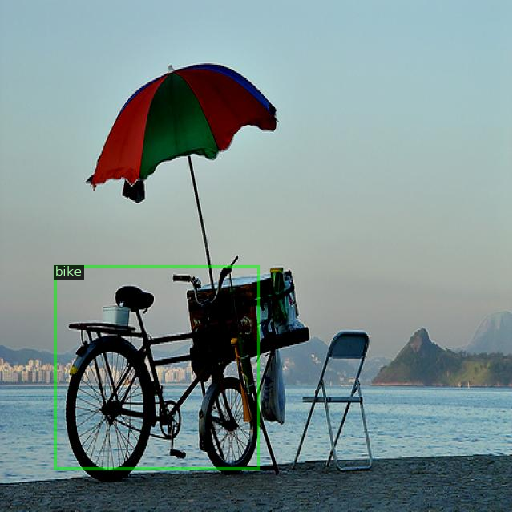

In [22]:
metadata = MetadataCatalog.get(TRAIN_DATA_SET_NAME)
dataset_train = DatasetCatalog.get(TRAIN_DATA_SET_NAME)

dataset_entry = dataset_train[0]
image = cv2.imread(dataset_entry["file_name"])

visualizer = Visualizer(
    image[:, :, ::-1],
    metadata=metadata,
    scale=0.8,
    instance_mode=ColorMode.IMAGE_BW
)

out = visualizer.draw_dataset_dict(dataset_entry)
cv2_imshow(out.get_image()[:, :, ::-1])

## Train Model Using Custom COCO Format Dataset

### Configuration

In [23]:
# HYPERPARAMETERS
ARCHITECTURE = "mask_rcnn_R_101_FPN_3x"
CONFIG_FILE_PATH = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"
MAX_ITER = 1000
EVAL_PERIOD = 200
BASE_LR = 0.001
NUM_CLASSES = 2

# OUTPUT DIR
OUTPUT_DIR_PATH = os.path.join(
    DATA_SET_NAME,
    ARCHITECTURE,
    datetime.now().strftime('%d-%m-%Y-%H-%M-%S')
)

os.makedirs(OUTPUT_DIR_PATH, exist_ok=True)

In [24]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE_PATH)
cfg.DATASETS.TRAIN = (TRAIN_DATA_SET_NAME,)
cfg.DATASETS.TEST = (TEST_DATA_SET_NAME,)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.TEST.EVAL_PERIOD = EVAL_PERIOD
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = MAX_ITER
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
cfg.OUTPUT_DIR = OUTPUT_DIR_PATH

### Training

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir $OUTPUT_DIR_PATH

### Evaluation

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [ ]:
dataset_valid = DatasetCatalog.get(VALID_DATA_SET_NAME)

for d in dataset_valid:
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    visualizer = Visualizer(
        img[:, :, ::-1],
        metadata=metadata,
        scale=0.8,
        instance_mode=ColorMode.IMAGE_BW
    )
    out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])